In [132]:
import os
import tarfile
import urllib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
#preprocessing utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

#modeling utilities
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [1]:
#create the path to download the info

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [3]:
#define the funciton for download the info

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
#doit
fetch_housing_data()

In [5]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [6]:
housing = load_housing_data()
housing.head()

#load the info into a pandas dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
#shows the info of columns and general info for dataframe
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
#counts the rows with differents values of ocean_proximity
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

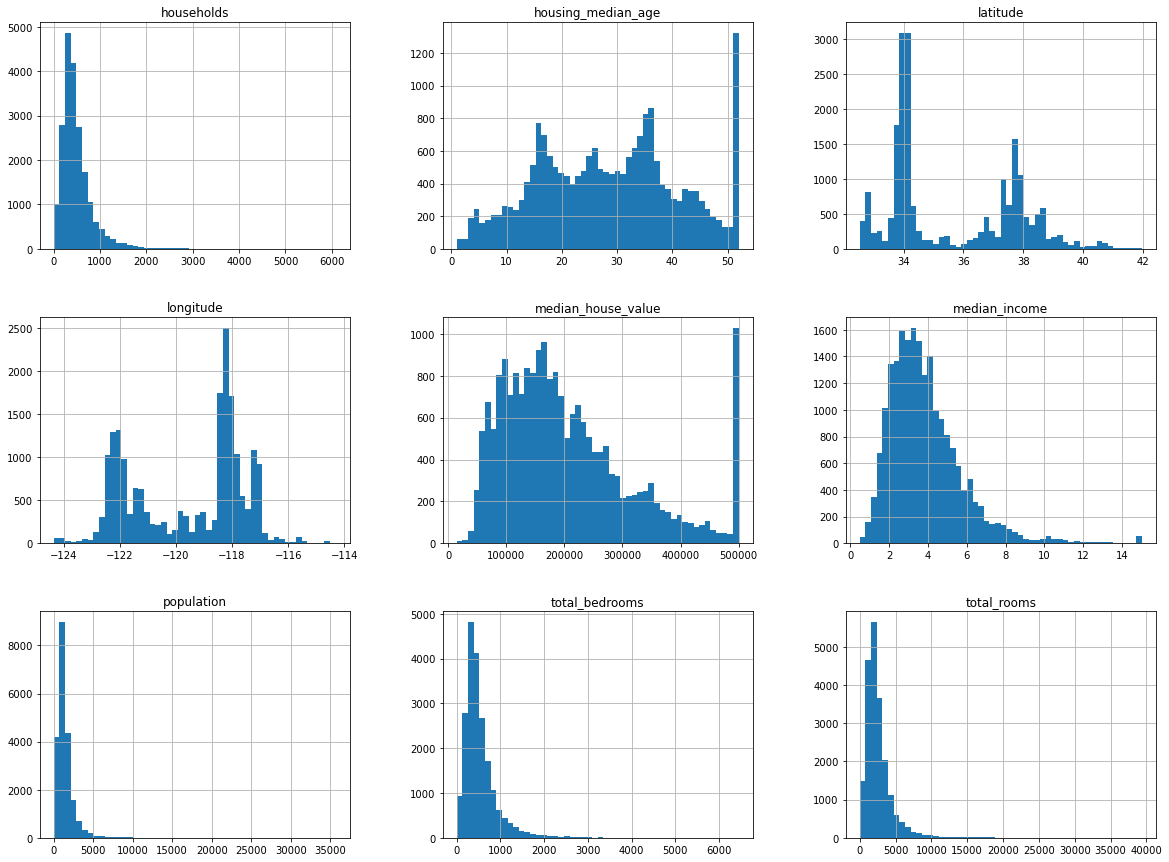

In [9]:
#plto an histogram for each numerical column
housing.hist(bins=50, figsize=(20, 15))
plt.show()

In [10]:
housing['housing_median_age'].value_counts()

52.0    1273
36.0     862
35.0     824
16.0     771
17.0     698
34.0     689
26.0     619
33.0     615
18.0     570
25.0     566
32.0     565
37.0     537
15.0     512
19.0     502
27.0     488
24.0     478
30.0     476
28.0     471
20.0     465
29.0     461
31.0     458
23.0     448
21.0     446
14.0     412
22.0     399
38.0     394
39.0     369
42.0     368
44.0     356
43.0     353
40.0     304
13.0     302
41.0     296
45.0     294
10.0     264
11.0     254
46.0     245
5.0      244
12.0     238
8.0      206
9.0      205
47.0     198
4.0      191
48.0     177
7.0      175
6.0      160
50.0     136
49.0     134
3.0       62
2.0       58
51.0      48
1.0        4
Name: housing_median_age, dtype: int64

**There are 3 important facts:**

* housing_median_age greater than 50 are masked with 52
* median_house_value greater than 500000 are masked with 500000
* All the different columns have its own scale, later on we have to re-scale all variables


**Hay 3 consideraciones importantes:**

* housing_median_age mayores a 50 estan etiquetados como 52
* median_house_value mayores a 500000 estan etiquetados como 500000
* Todas las columnas tienen su propia escala, posteriormente deberemos volver a escalar todas las variables

In [11]:
#create categories for income based on the values assign in 5 bins
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0, 1.5, 3, 4.5, 6, np.inf], labels=[1, 2, 3, 4, 5])

In [12]:
#split the data in train and test set, this is very important for measure the quality of a prediction
train_set_random, test_set_random = train_test_split(housing, test_size=0.2, random_state=42)

In [13]:
#this a advanced split technique, here you split the data knowing the bias for some categories
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [14]:

#here you can see the quality for the different kinds of split
print('Overall:')
overall_list = [x/len(housing) for x in housing.groupby(['income_cat'])['income_cat'].count().tolist()]
print(overall_list)
print('-'*20)

print('Random split:')
random_list = [x/len(train_set_random) for x in train_set_random.groupby(['income_cat'])['income_cat'].count().tolist()]
print(random_list)
distance_rand = [np.abs(1- x/y) for x, y in zip(overall_list, random_list)]
print("The error is: ", distance_rand)
print('-'*20)

print('Stratified split:')
strat_list = [x/len(strat_train_set) for x in strat_train_set.groupby(['income_cat'])['income_cat'].count().tolist()]
print(strat_list)
distance_rand = [np.abs(1- x/y) for x, y in zip(overall_list, strat_list)]
print("The error is: ", distance_rand)


Overall:
[0.039825581395348836, 0.3188468992248062, 0.3505813953488372, 0.17630813953488372, 0.11443798449612404]
--------------------
Random split:
[0.03972868217054264, 0.3174660852713178, 0.3485949612403101, 0.17853682170542637, 0.1156734496124031]
The error is:  [0.0024390243902439046, 0.004349484929416336, 0.0056984016678247595, 0.012483039348711089, 0.010680628272251247]
--------------------
Stratified split:
[0.03984980620155039, 0.318859011627907, 0.350593507751938, 0.17629602713178294, 0.1144016472868217]
The error is:  [0.0006079027355623268, 3.7986704653381054e-05, 3.454828122306797e-05, 6.870491240129617e-05, 0.0003176283748016484]


In [15]:
#drop the column income_cat in train and test dataset
for dataset in (strat_train_set, strat_test_set):
    dataset.drop('income_cat', axis=1, inplace=True)

In [16]:
housing = strat_train_set.copy()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


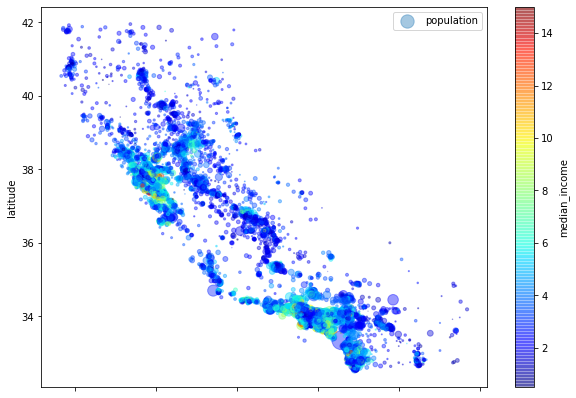

In [17]:
#starting the EDA, here using an scatterplot to know the spacial distribution of data

housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=housing['population']/100, c='median_income', cmap='jet', colorbar=True, figsize=(10, 7), label='population')
plt.legend()

In [18]:
#use the corr functio to know the pearson correlation of features (here I only want to know the relation for median_house_value)
housing.corr()['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

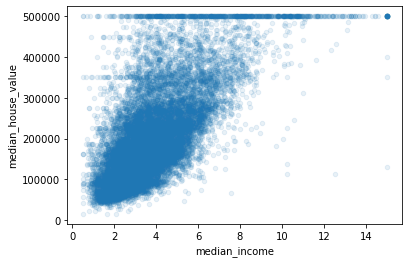

In [19]:
#scatter plot to identify the median income and median house value. We can see a positive relation, with some special cases
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

In [20]:
#in most cases, is useful to create new features, this will help in the fitting model
housing['room_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [21]:
#again a correlation
housing.corr()['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
room_per_household          0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [ ]:
#remove the target feature from the features
housing_features = housing.drop('median_house_value', axis=1)
housing_labels = housing['median_house_value']

In [58]:
#create an imputer, to replace the values with the specified param, in this case the median
imputer = SimpleImputer(strategy='median')
housing_num = housing_features.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [59]:
#imputer applied
imputer.statistics_
x=imputer.transform(housing_num)
housing_tr = pd.DataFrame(x, columns=housing_num.columns, index=housing_num.index)

In [60]:
#prove the non-null columns
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 16512 non-null  float64
 1   latitude                  16512 non-null  float64
 2   housing_median_age        16512 non-null  float64
 3   total_rooms               16512 non-null  float64
 4   total_bedrooms            16512 non-null  float64
 5   population                16512 non-null  float64
 6   households                16512 non-null  float64
 7   median_income             16512 non-null  float64
 8   room_per_household        16512 non-null  float64
 9   bedrooms_per_room         16512 non-null  float64
 10  population_per_household  16512 non-null  float64
dtypes: float64(11)
memory usage: 1.5 MB


In [61]:
#create a pipeline, this is very useful when you want to replicate multiple steps of transformation
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [63]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ("numerical", num_pipeline, num_attribs),
    ("categorical", OneHotEncoder(), cat_attribs)
])

In [67]:
housing_prepared = full_pipeline.fit_transform(housing_features)

In [69]:
#the first model to use is linear regession
linear_reg = LinearRegression()
linear_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [96]:
#fit the model, and show the RMSE as error measure
linear_predictions = linear_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, linear_predictions)
np.sqrt(lin_mse)

68161.22644433199

(0.0, 700000.0)

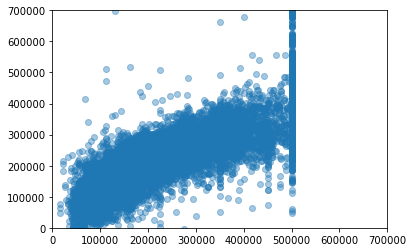

In [97]:
#scatter plot to understand the relation between the real values and the predictions
plt.scatter(housing_labels, housing_predictions, alpha=0.4)
plt.ylim(0,700000)
plt.xlim(0,700000)

In [98]:
#the second model to use is a tree regressor, again we use the RMSE as error measure
tree_regressor = DecisionTreeRegressor()
tree_regressor.fit(housing_prepared, housing_labels)

tree_predictions = tree_regressor.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, tree_predictions)
np.sqrt(tree_mse)

0.0

Overfitting!!!

In [123]:
def display_errors(scores):
    scores_ = np.sqrt(-scores)
    print('mean:', scores_.mean())
    print('std:', scores_.std())

In [126]:
#is better to use cross validations, for a accurate result

tree_scores = cross_val_score(tree_regressor, housing_prepared, housing_labels,
                             scoring='neg_mean_squared_error', cv=10)
lin_scores = cross_val_score(linear_reg, housing_prepared, housing_labels,
                             scoring='neg_mean_squared_error', cv=10)

In [127]:
#display the errors using cross validation
display_errors(tree_scores)
print('*'*10)
display_errors(lin_scores)

mean: 70637.49098930265
std: 2285.0881096501603
**********
mean: 68480.58471553595
std: 2845.5843092650834


In [129]:
#lastly we use a randome forest, again using the RMSE as error measure
rand_forest_reg = RandomForestRegressor()
rand_forest_reg.fit(housing_prepared, housing_labels)
rand_forest_predictions = rand_forest_reg.predict(housing_prepared)
rand_forest_mse = mean_squared_error(rand_forest_predictions, housing_labels)

np.sqrt(rand_forest_mse)

18627.98765716819

In [130]:
rand_for_scores = cross_val_score(rand_forest_reg, housing_prepared, housing_labels, 
                                  cv=10, scoring='neg_mean_squared_error')

In [131]:
display_errors(rand_for_scores)

mean: 50092.1281606437
std: 1944.9166072536418


Better than others, but is still overfitted

In [140]:
#set the params for a grid search, searching a better performance in test set
forest_reg_grid = RandomForestRegressor()
params_grid = [
    {'bootstrap':[True, False], 'n_estimators':[3,10,30,50,100], 'max_features':[2,4,6,8,10]},
]

In [148]:
#the set up of grid search
grid_search = GridSearchCV(forest_reg_grid, params_grid, cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'bootstrap': [True, False],
                          'max_features': [2, 4, 6, 8, 10],
                          'n_estimators': [3, 10, 30, 50, 100]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [149]:
#the params for the best result
grid_search.best_params_

{'bootstrap': False, 'max_features': 6, 'n_estimators': 100}

In [147]:
#see the iterations
cv_results = grid_search.cv_results_

for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(np.sqrt(-mean_score), '->', params)

64666.85220107784 -> {'bootstrap': True, 'max_features': 2, 'n_estimators': 3}
54835.03952284057 -> {'bootstrap': True, 'max_features': 2, 'n_estimators': 10}
52710.55350709038 -> {'bootstrap': True, 'max_features': 2, 'n_estimators': 30}
52519.30355540104 -> {'bootstrap': True, 'max_features': 2, 'n_estimators': 50}
51949.387215695446 -> {'bootstrap': True, 'max_features': 2, 'n_estimators': 100}
59830.78523612858 -> {'bootstrap': True, 'max_features': 4, 'n_estimators': 3}
52887.408649167875 -> {'bootstrap': True, 'max_features': 4, 'n_estimators': 10}
50065.61047384855 -> {'bootstrap': True, 'max_features': 4, 'n_estimators': 30}
50118.25199754757 -> {'bootstrap': True, 'max_features': 4, 'n_estimators': 50}
49835.175066055126 -> {'bootstrap': True, 'max_features': 4, 'n_estimators': 100}
59675.41940391309 -> {'bootstrap': True, 'max_features': 6, 'n_estimators': 3}
52119.921948721836 -> {'bootstrap': True, 'max_features': 6, 'n_estimators': 10}
49871.44869062771 -> {'bootstrap': Tr

In [157]:
#we can see the importance of features, this is useful for next improves of models
grid_search.best_estimator_.feature_importances_

array([8.18643602e-02, 6.95515459e-02, 4.09726861e-02, 1.71220529e-02,
       1.58675163e-02, 1.67944055e-02, 1.57378389e-02, 3.16032691e-01,
       6.09727895e-02, 7.70866641e-02, 1.05539019e-01, 9.91468852e-03,
       1.63914111e-01, 6.45729369e-05, 3.91538908e-03, 4.64966957e-03])

In [165]:
list(zip(housing_features.columns, grid_search.best_estimator_.feature_importances_))

[('longitude', 0.08186436015697991),
 ('latitude', 0.06955154591011667),
 ('housing_median_age', 0.040972686078573094),
 ('total_rooms', 0.017122052902371204),
 ('total_bedrooms', 0.015867516287094242),
 ('population', 0.016794405497019826),
 ('households', 0.01573783885265896),
 ('median_income', 0.3160326912177808),
 ('ocean_proximity', 0.060972789505843776),
 ('room_per_household', 0.0770866640897244),
 ('bedrooms_per_room', 0.10553901876593735),
 ('population_per_household', 0.009914688522229346)]

In [220]:
numerical_columns = housing_features.drop('ocean_proximity', axis=1).columns.to_list()
encoder_categories = list(full_pipeline.transformers_[1][1].categories_[0])
numerical_columns.extend(encoder_categories)

In [227]:
sorted(list(zip(grid_search.best_estimator_.feature_importances_, numerical_columns)), reverse=True)

[(0.3160326912177808, 'median_income'),
 (0.16391411062885874, 'INLAND'),
 (0.10553901876593735, 'population_per_household'),
 (0.08186436015697991, 'longitude'),
 (0.0770866640897244, 'bedrooms_per_room'),
 (0.06955154591011667, 'latitude'),
 (0.060972789505843776, 'room_per_household'),
 (0.040972686078573094, 'housing_median_age'),
 (0.017122052902371204, 'total_rooms'),
 (0.016794405497019826, 'population'),
 (0.015867516287094242, 'total_bedrooms'),
 (0.01573783885265896, 'households'),
 (0.009914688522229346, '<1H OCEAN'),
 (0.004649669569830128, 'NEAR OCEAN'),
 (0.003915389078122904, 'NEAR BAY'),
 (6.457293685861634e-05, 'ISLAND')]